# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.7244

947/947 [==============================] - 2759s 3s/step - loss: 0.8350 - accuracy: 0.7244 - val_loss: 4.4035 - val_accuracy: 0.6620
Epoch 2/200
947/947 [==============================] - 2503s 3s/step - loss: 0.7170 - accuracy: 0.7546 - val_loss: 6.4968 - val_accuracy: 0.2800
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7687

947/947 [==============================] - 2590s 3s/step - loss: 0.6731 - accuracy: 0.7687 - val_loss: 3.2592 - val_accuracy: 0.4820
Epoch 4/200
947/947 [==============================] - 2538s 3s/step - loss: 0.6526 - accuracy: 0.7727 - val_loss: 4.2306 - val_accuracy: 0.6592
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.7819

947/947 [==============================] - 2631s 3s/step - loss: 0.6259 - accuracy: 0.7819 - val_loss: 1.0450 - val_accuracy: 0.7095
Epoch 6/200
947/947 [==============================] - 2496s 3s/step - loss: 0.6052 - accuracy: 0.7849 - val_loss: 1.4676 - val_accuracy: 0.7047
Epoch 7/200
947/947 [==============================] - 2481s 3s/step - loss: 0.5907 - accuracy: 0.7907 - val_loss: 1.5799 - val_accuracy: 0.5512
Epoch 8/200
947/947 [==============================] - 2509s 3s/step - loss: 0.5706 - accuracy: 0.7980 - val_loss: 1.2776 - val_accuracy: 0.7090
Epoch 9/200
947/947 [==============================] - 2509s 3s/step - loss: 0.5589 - accuracy: 0.8023 - val_loss: 1.2142 - val_accuracy: 0.7476
Epoch 10/200
947/947 [==============================] - 2513s 3s/step - loss: 0.5460 - accuracy: 0.8054 - val_loss: 1.1199 - val_accuracy: 0.6600
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.8096

947/947 [==============================] - 2623s 3s/step - loss: 0.5361 - accuracy: 0.8096 - val_loss: 1.0237 - val_accuracy: 0.6785
Epoch 12/200
947/947 [==============================] - 2506s 3s/step - loss: 0.5257 - accuracy: 0.8136 - val_loss: 1.0533 - val_accuracy: 0.7028
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.8158

947/947 [==============================] - 2571s 3s/step - loss: 0.5162 - accuracy: 0.8158 - val_loss: 0.6405 - val_accuracy: 0.7912
Epoch 14/200
947/947 [==============================] - 2503s 3s/step - loss: 0.5097 - accuracy: 0.8173 - val_loss: 0.9142 - val_accuracy: 0.7695
Epoch 15/200
947/947 [==============================] - 2497s 3s/step - loss: 0.5000 - accuracy: 0.8232 - val_loss: 0.6647 - val_accuracy: 0.7848
Epoch 16/200
947/947 [==============================] - 2561s 3s/step - loss: 0.4905 - accuracy: 0.8249 - val_loss: 0.7239 - val_accuracy: 0.7965
Epoch 17/200
947/947 [==============================] - 2495s 3s/step - loss: 0.4865 - accuracy: 0.8240 - val_loss: 0.8703 - val_accuracy: 0.7789
Epoch 18/200
947/947 [==============================] - 2496s 3s/step - loss: 0.4752 - accuracy: 0.8290 - val_loss: 0.9932 - val_accuracy: 0.7024
Epoch 19/200
947/947 [==============================] - 2502s 3s/step - loss: 0.4683 - accuracy: 0.8309 - val_loss: 0.7688 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 292s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9384341695270421,
 'basal cell carcinoma': 0.9752270663033604,
 'dermatofibroma': 0.9515649679940146,
 'melanoma': 0.8950662949654672,
 'nevus': 0.9416163355230321,
 'pigmented benign keratosis': 0.9695992179863148,
 'seborrheic keratosis': 0.924418085412525,
 'solar lentigo': 0.9456787167823797,
 'squamous cell carcinoma': 0.9149525020569975,
 'vascular lesion': 0.9991716973185455}

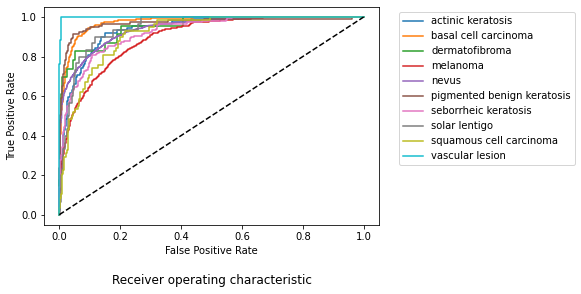

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

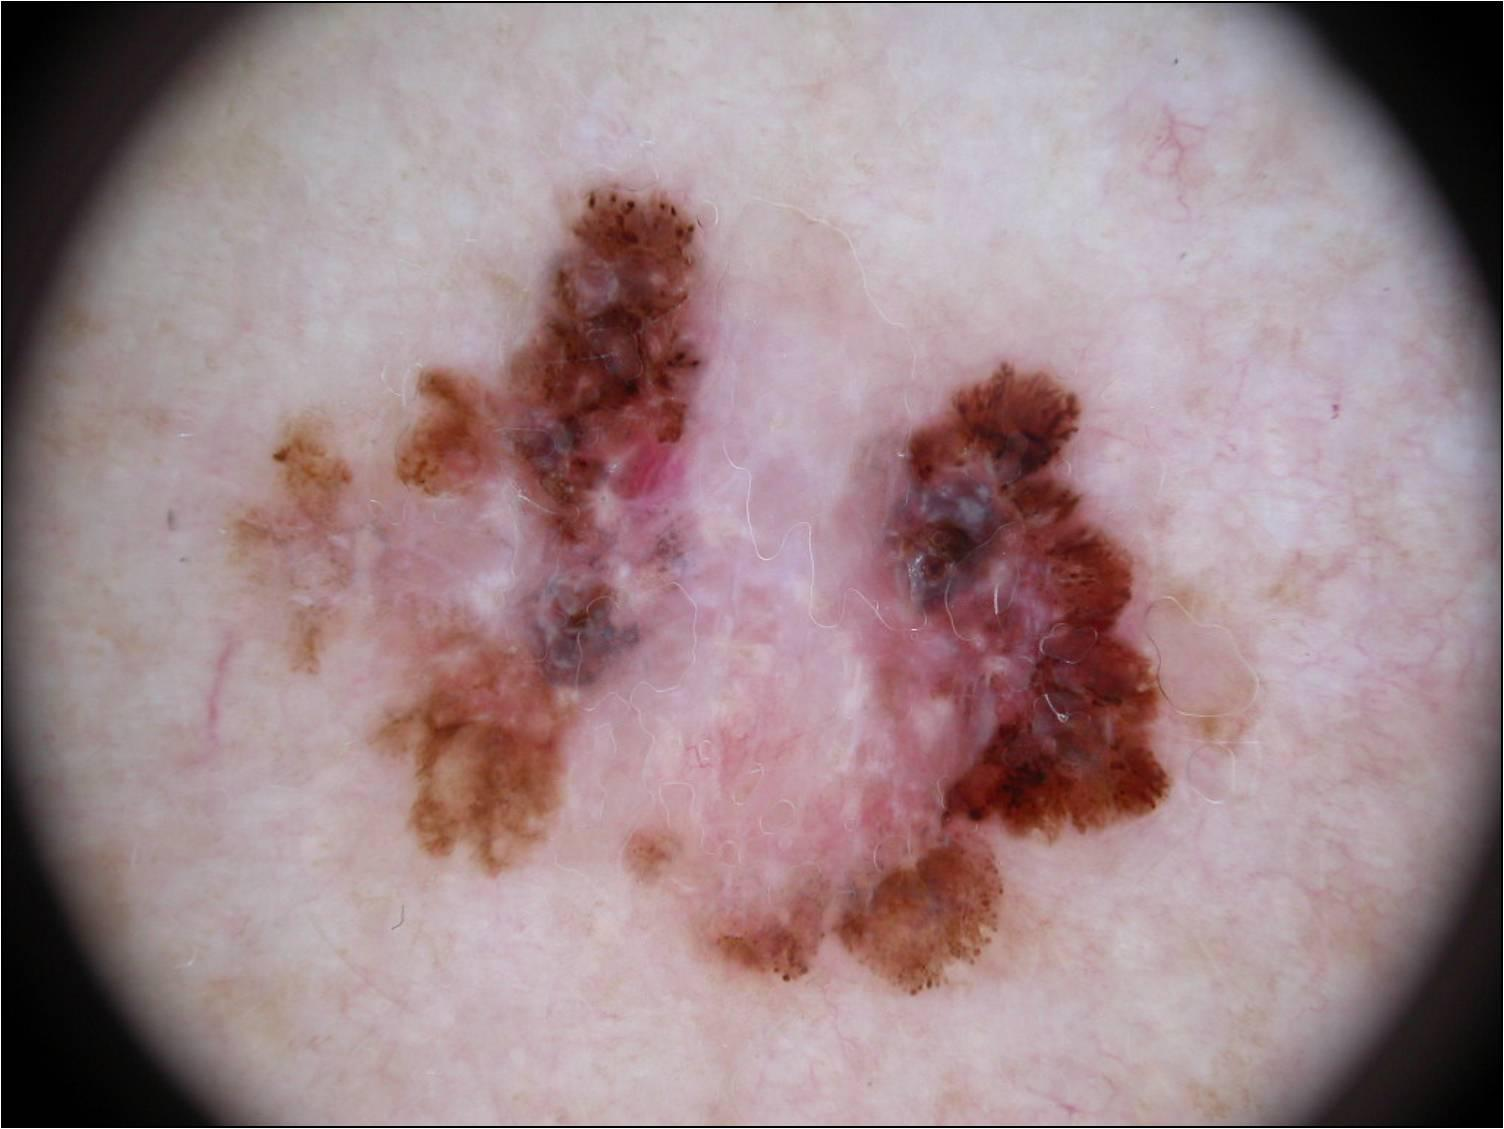

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

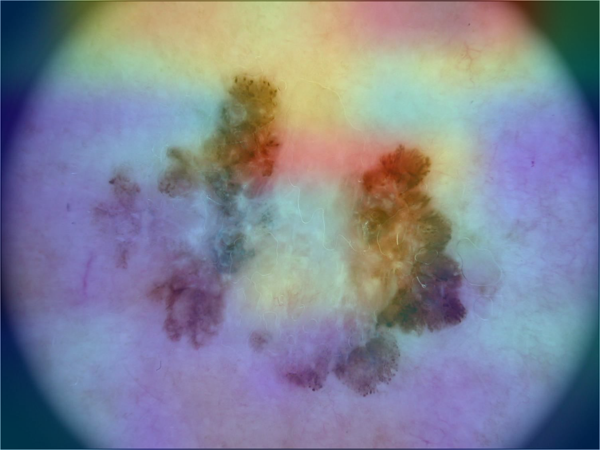

In [23]:
display_gradcam(melanoma_im_path, heatmap)